In [2]:
import wandb
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv("../.env")

True

In [3]:
########################################################################################
# query data from wandb

# add data to frames
api = wandb.Api()

data_description_map = {
    "vox2": "voxceleb2 (1M files shared between 5994 speakers)",
    "tiny-few": "tiny-few (50k files shared between 100 speakers)",
    "tiny-low": "tiny-low (8 files sampled from 1 session for each 5994 speakers)",
    "tiny-high": "tiny-high (8 files sampled from 8 sessions for each 5994 speakers)",
}


def load_runs(name: str):
    runs = api.runs(name)
    df = pd.DataFrame(columns=["lr", "eer", "data", "network"])

    for r in runs:
        tags = r.tags

        if r.state == "running":
            continue

        if (
            "naive_grid" in tags
             or "detailed_grid" in tags
        ):
            lr = r.config["optim"]["algo"]["lr"]
            eer = r.summary["test_eer_original"]

            if eer >= 0.25:
                eer = 0.25

            if "vox2_full" in tags:
                data = data_description_map["vox2"]
            elif "tiny_few" in tags:
                data = data_description_map["tiny-few"]
            elif "tiny_many_high" in tags:
                data = data_description_map["tiny-high"]
            elif "tiny_many_low" in tags:
                data = data_description_map["tiny-low"]
            elif "tiny_many" in tags:
                continue
            else:
                raise ValueError(f"undetermined dataset from {tags=}")

            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "lr": [lr],
                            "eer": [eer],
                            "data": [data],
                            "network": [name],
                        }
                    ),
                ],
                ignore_index=True,
            )

    return df


df_xvector = load_runs("xvector")
df_ecapa = load_runs("ecapa")
df_w2v2 = load_runs("wav2vec2")

df = pd.concat([df_xvector, df_ecapa, df_w2v2], ignore_index=True)

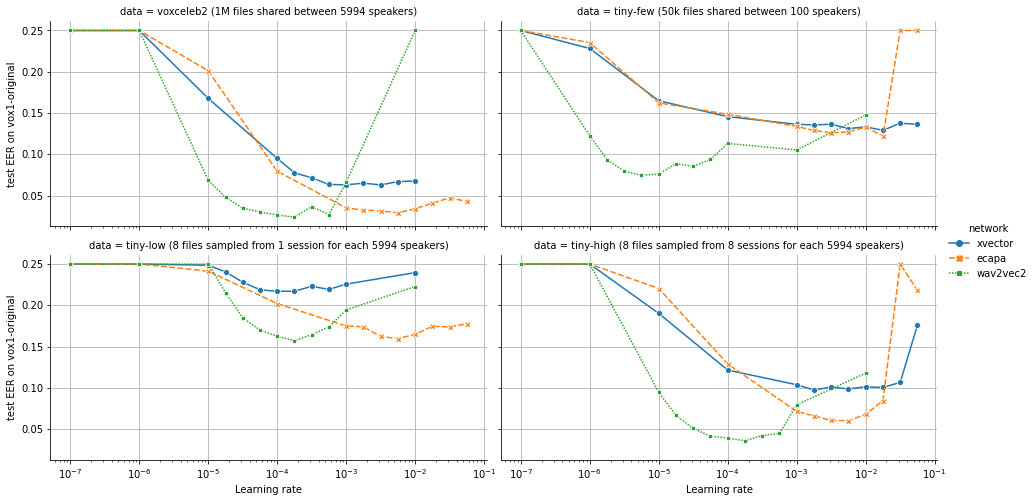

In [4]:
# a4 is 8.3 x 11.7 (width x height in inches)
a4_width = 8.3
a4_height = 11.7

width = 0.8 * a4_width
height = 0.3 * a4_height
aspect = width / height

with sns.axes_style(rc={
    "axes.grid": True,
    "axes.grid.which": "both",
    "xticks.bottom": True,
    "xticks.minor.bottom": True,
    "xtick.minor.visible": True,
    "xtick.minor.size":    2,
    "xtick.minor.width":   0.6     # minor tick width in points
}):
    fig = sns.relplot(
        data=df,
        x="lr",
        y="eer",
        hue="network",
        style="network",
        col="data",
        markers=True,
        dashes=True,
        kind="line",
        col_wrap=2,
        col_order=[
            data_description_map["vox2"],
            data_description_map["tiny-few"],
            data_description_map["tiny-low"],
            data_description_map["tiny-high"],
        ],
        height=height,
        aspect=aspect,
    )

    fig.set(xscale="log")
    fig.set(xlabel="Learning rate")
    fig.set(ylabel="test EER on vox1-original")
    plt.savefig("plot_four.png")
    plt.savefig("plot_four.pdf")
    plt.show()


In [5]:
df_copy = df.copy(deep=True)
df_copy["lr"] = df_copy['lr'].apply("{:.2E}".format)
# sort to make aggregate by first work
df_copy = df_copy.sort_values(by='eer', ascending=True)
df_grouped = df_copy.groupby(by=["network", "data"])

In [6]:
df_grouped.agg(lr=("lr", "first"), eer=("eer", "min"), count=("eer", "count"))

lr  \
network  data                                                           
ecapa    tiny-few (50k files shared between 100 speakers)    1.78E-02   
         tiny-high (8 files sampled from 8 sessions for ...  5.62E-03   
         tiny-low (8 files sampled from 1 session for ea...  5.62E-03   
         voxceleb2 (1M files shared between 5994 speakers)   5.62E-03   
wav2vec2 tiny-few (50k files shared between 100 speakers)    5.62E-06   
         tiny-high (8 files sampled from 8 sessions for ...  1.78E-04   
         tiny-low (8 files sampled from 1 session for ea...  1.78E-04   
         voxceleb2 (1M files shared between 5994 speakers)   1.78E-04   
xvector  tiny-few (50k files shared between 100 speakers)    1.78E-02   
         tiny-high (8 files sampled from 8 sessions for ...  1.78E-03   
         tiny-low (8 files sampled from 1 session for ea...  1.00E-04   
         voxceleb2 (1M files shared between 5994 speakers)   3.16E-03   

                                                                  eer  count  
network  data                                                                 
ecapa    tiny-few (50k files shared between 100 speakers)    0.121902     12  
         tiny-high (8 files sampled from 8 sessions for ...  0.060419     12  
         tiny-low (8 files sampled from 1 session for ea...  0.159658     12  
         voxceleb2 (1M files shared between 5994 speakers)   0.029093     12  
wav2vec2 tiny-few (50k files shared between 100 speakers)    0.074645     12  
         tiny-high (8 files sampled from 8 sessions for ...  0.036007     12  
         tiny-low (8 files sampled from 1 session for ea...  0.157212     12  
         voxceleb2 (1M files shared between 5994 speakers)   0.023978     12  
xvector  tiny-few (50k files shared between 100 speakers)    0.129087     12  
         tiny-high (8 files sampled from 8 sessions for ...  0.097507     12  
         tiny-low (8 files sampled from 1 session for ea...  0.216998     12  
         voxceleb2 (1M files shared between 5994 speakers)   0.062972     12